In [1]:
from pyspark import SparkContext
import pandas as pd

In [15]:
import re
import csv
from datetime import datetime
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt


# pip install workalendar
# https://github.com/novafloss/workalendar
from workalendar.europe import Italy

In [17]:
cal = Italy()

def def_is_holiday(dt_obj):
    if(cal.is_working_day(dt_obj)):
        return 0
    else:
        return 1

In [31]:
row = namedtuple("prodotto", ['zona','area','sottoarea','categoria','timestamp','giorno_della_settimana', 'giorno_del_mese',
                              'giorno_dell_anno', 'mese', 'anno','festivo','vendite'])

In [47]:
def do_parse(x):
    # Oggetto Datetime
    dt_obj = datetime.strptime(str(x[4]), '"%Y-%m-%d"')
    
    return row(
        zona = int(re.sub("[^0-9]", "", str(x[0]))),
        area = int(re.sub("[^0-9]", "", x[1])),
        sottoarea = int(re.sub("[^0-9]", "", x[2])),
        categoria = int(re.sub("[^0-9]", "", x[3])),
        timestamp = int(dt_obj.strftime("%s")),
        giorno_della_settimana = int(dt_obj.weekday()),
        giorno_del_mese = int(dt_obj.weekday()),
        giorno_dell_anno = int(dt_obj.timetuple().tm_yday),
        mese = int(dt_obj.strftime("%m")),
        anno = int(dt_obj.strftime("%Y")),
        festivo = def_is_holiday(dt_obj),
        vendite = int(x[5])
        )

def parse(sc,filepath):
    rawRdd = sc.textFile(filepath)
    
    header = rawRdd.first()

    # Togliamo l'header
    rawRdd = rawRdd.filter(lambda x: x != header)

    # Togliamo le righe vuote
    rawRdd = rawRdd.filter(lambda x: x != "")
    
    return rawRdd.map(lambda x: x.split(",")).map(lambda x: do_parse(x))

In [106]:
rdd = parse(sc,"dataset_polimi.csv")
rdd.take(1)

[prodotto(zona=1, area=1, sottoarea=5, categoria=1, timestamp=1388534400, giorno_della_settimana=2, giorno_del_mese=2, giorno_dell_anno=1, mese=1, anno=2014, festivo=1, vendite=0)]

Data Analysis
--

Zone
----

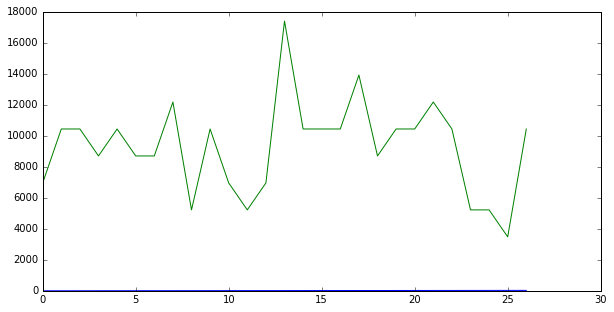

In [96]:
fig = plt.figure(figsize=(10,5))
zone = (rdd.map(lambda x: (x.zona,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(zone)

Aree
---

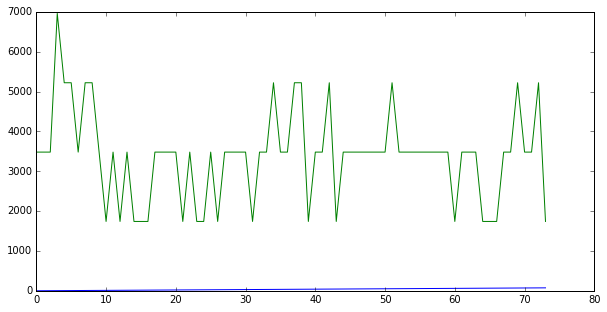

In [95]:
fig = plt.figure(figsize=(10,5))
aree = (rdd.map(lambda x: (x.area,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(aree)

Categorie
---

In [22]:
categorie = (rdd.map(lambda x: (x.categoria,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
categorie

[(1, 125280), (2, 125280)]

Settimana
---

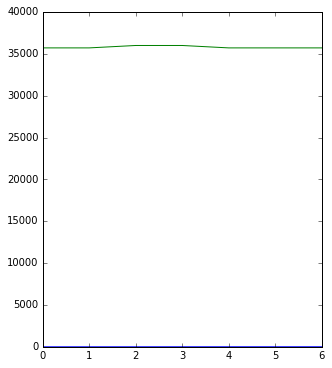

In [93]:
fig = plt.figure(figsize=(5,6))
giorni = (rdd.map(lambda x: (x.giorno_della_settimana,1))
                       .reduceByKey(lambda x,y: x+y)).collect()
plot = plt.plot(giorni)

# Pandas
if you cannot stay without it

In [67]:
collected_rdd = rdd.collect()

In [68]:
df = pd.DataFrame.from_records(collected_rdd,columns = ['zona','area','sottoarea','categoria','timestamp','giorno_della_settimana', 'giorno_del_mese',
                              'giorno_dell_anno', 'mese', 'anno','festivo','vendite'])

In [64]:
# df = df.drop('timestamp',1)

In [69]:
df

,zona,area,sottoarea,categoria,timestamp,giorno_della_settimana,giorno_del_mese,giorno_dell_anno,mese,anno,festivo,vendite
0,1,1,5,1,1388530800,2,2,1,1,2014,1,0
1,1,1,5,1,1388617200,3,3,2,1,2014,0,5
2,1,1,5,1,1388703600,4,4,3,1,2014,0,3
3,1,1,5,1,1388790000,5,5,4,1,2014,1,0
4,1,1,5,1,1388876400,6,6,5,1,2014,1,0
5,1,1,5,1,1388962800,0,0,6,1,2014,1,0
6,1,1,5,1,1389049200,1,1,7,1,2014,0,6
7,1,1,5,1,1389135600,2,2,8,1,2014,0,9
8,1,1,5,1,1389222000,3,3,9,1,2014,0,14
9,1,1,5,1,1389308400,4,4,10,1,2014,0,10
